In [1]:
import numpy as np
import random
import pandas as pd
import torch as t
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/Users/paul/anaconda3/envs/acd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the CSV file to verify it
df_sentences = pd.read_csv('../datasets/ilikecats.csv')

# Display the first few entries
print(df_sentences.head())

# Filter the DataFrame for rows where the Label column is 'Animal'
animal_sentences = df_sentences[df_sentences['Label'] == 'Animal']['Sentence'].tolist()
non_animal_sentences = df_sentences[df_sentences['Label'] == 'Non-Animal']['Sentence'].tolist()


    Label           Sentence
0  Animal       I like cats.
1  Animal       I like dogs.
2  Animal  I like elephants.
3  Animal     I like tigers.
4  Animal      I like birds.


In [3]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token



In [ ]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

_ = model.eval()

In [4]:
# Global container to store activations (GPT2)
activations = {}

def get_activation(name):
    # closure to store activation
    def hook(model, input, output):
        activations[name] = output[0].detach()
    return hook

# Attaching hooks to each layer of the model
for i, layer in enumerate(model.transformer.h):
    layer.register_forward_hook(get_activation(f'Layer_{i}'))


In [5]:
# Print max number of layers and max number of tokens
print(f"Number of layers = {len(model.transformer.h)}")
max_tokens = tokenizer(df_sentences['Sentence'].tolist(), return_tensors="pt", padding=True, truncation=True)['input_ids'].shape[-1]
print(f"Number of tokens = {max_tokens}")

Number of layers = 12
Number of tokens = 10


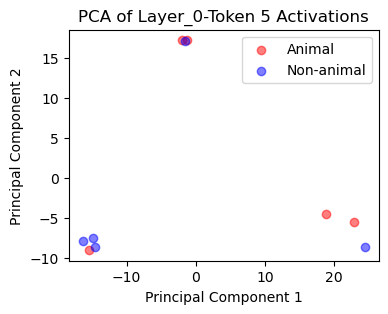

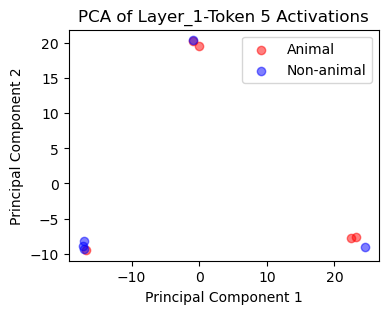

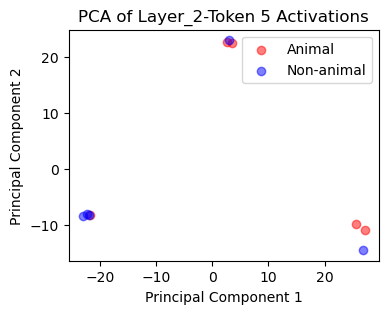

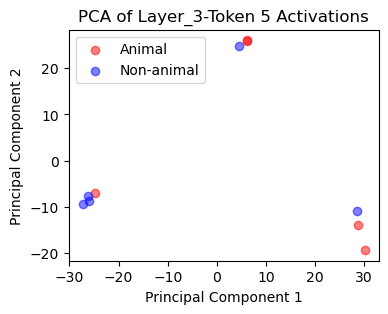

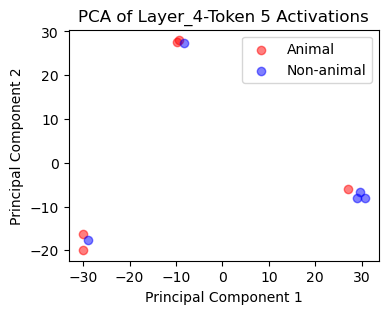

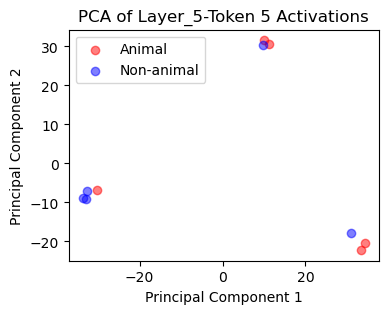

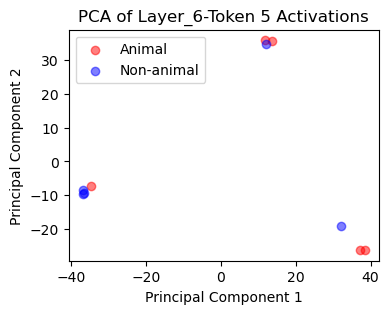

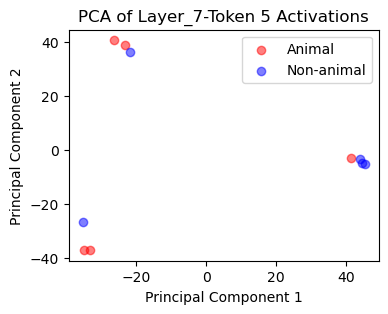

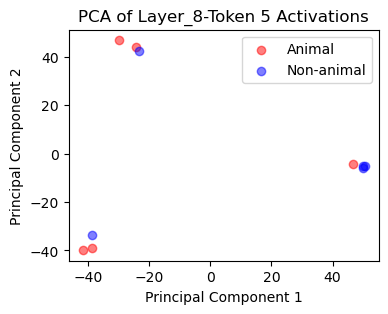

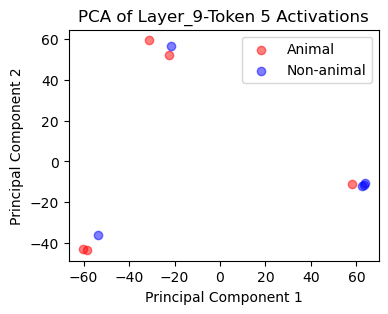

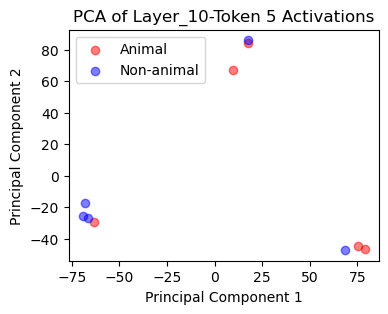

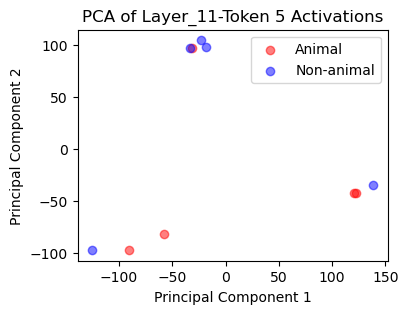

In [6]:
# Parameters for looping
num_samples = 5
layer_names = ['Layer_{}'.format(i) for i in range(0, 12)]  # Adjust as needed based on your model structure
token_indices = [5]  # Example token indices

# Shuffle sentences
random.shuffle(animal_sentences)
random.shuffle(non_animal_sentences)

# Process sentences and get activations
inputs = tokenizer(animal_sentences[0:num_samples], return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)
animal_activations = activations.copy()

activations = {}

inputs = tokenizer(non_animal_sentences[0:num_samples], return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)
non_animal_activations = activations.copy()

# Loop over each layer and token
for layer_name in layer_names:
    for token_num in token_indices:
        try:
            # Extract activations for the current layer and token
            animal_activations_layer_token = animal_activations[layer_name][:, token_num, :].numpy()
            non_animal_activations_layer_token = non_animal_activations[layer_name][:, token_num, :].numpy()
            
            # Combine datasets
            combined_activations = np.vstack((animal_activations_layer_token, non_animal_activations_layer_token))
            labels = np.array([0] * len(animal_activations_layer_token) + [1] * len(non_animal_activations_layer_token))
            
            # Perform PCA
            pca = PCA(n_components=2)  # 2D for easy plotting
            reduced_activations = pca.fit_transform(combined_activations)
            
            # Plotting
            plt.figure(figsize=(4, 3))
            plt.scatter(reduced_activations[labels == 0, 0], reduced_activations[labels == 0, 1], c='red', label='Animal', alpha=0.5)
            plt.scatter(reduced_activations[labels == 1, 0], reduced_activations[labels == 1, 1], c='blue', label='Non-animal', alpha=0.5)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.legend()
            plt.title(f'PCA of {layer_name}-Token {token_num} Activations')
            plt.show()
            
        except Exception as e:
            print(f"Error processing {layer_name}-Token {token_num}: {e}")
